# Import Libraries

In [ ]:
import json
import pandas as pd
import requests
import datetime
import csv
from binance import Client
#import binance_keys
import matplotlib.pyplot as plt
binance_client = Client()
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### Что влияет на ставки 

* Цены на деривативы и спотовые активы
* Объемы торгов на спот рынке и рынке деривативов 
* Ставки по кредитам
* Фаза рынка
* Направление движения цены за период

* Лог-доходность за последние 8 часов
* Общий тренд валютной пары в данный момент 
* RSI
* DrawDown

* MACD
* TSI
* Check binance funding formula

## Что поправить

* Переписать в сбор данных даты нчала и конца в переменные
* График what impacts сделать больше


# Сбор Данных

## Prices

In [ ]:
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.datetime.strptime('11/09/2020 03:00:00', '%d/%m/%Y %H:%M:%S'))
toDate = str(datetime.datetime.strptime('11/11/2022 03:00:00', '%d/%m/%Y %H:%M:%S'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_1HOUR

In [ ]:
def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low", 'close', "volume"]
    df = df.reindex(columns=column_names)
    return df

In [ ]:
def GetHistoricalFutData(symbol, interval, fromDate, toDate):
    klines = client.futures_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low",'close', "volume"]
    df = df.reindex(columns=column_names)
    return df


In [ ]:
df_spot = GetHistoricalData(symbol, interval, fromDate, toDate)
df_fut = GetHistoricalFutData(symbol, interval, fromDate, toDate)

## Funding rates

In [ ]:
start_time = (pd.to_datetime(today)- pd.Timestamp("1970-01-01"))// pd.Timedelta('1s')

In [ ]:
start_time

1668878218

In [ ]:
# Переписать эту 

In [ ]:
start_time = (pd.to_datetime('2020-09-11')- pd.Timestamp("1970-01-01"))// pd.Timedelta('1s')
end_time = (pd.to_datetime('2022-11-14')- pd.Timestamp("1970-01-01"))// pd.Timedelta('1s')

In [ ]:
binance_endpoint = 'https://fapi.binance.com'
binance_BTCUSDT_hist = requests.get(binance_endpoint+'/fapi/v1/fundingRate',
                                    {'symbol':'ETHUSDT','startTime': start_time*1000,
                                     'endTime': end_time*1000,'limit':1000}).json()
binance_funding = pd.DataFrame(binance_BTCUSDT_hist)


binance_funding["fundingTime"] = [datetime.datetime.fromtimestamp(x / 1000) 
                                  for x in binance_funding["fundingTime"]]

binance_funding['dateTime'] = pd.to_datetime(binance_funding["fundingTime"], unit='ms')
binance_funding['date'] = binance_funding.dateTime.dt.strftime("%d/%m/%Y")
binance_funding['time'] = binance_funding.dateTime.dt.strftime("%H:%M:%S")


binance_funding = binance_funding.drop(["symbol", 'dateTime'], axis = 1)


In [ ]:
svod = df_spot.merge(df_fut, on = ["date", 'time'], how = 'left', suffixes = ["_spot", '_fut'])
svod = binance_funding.merge(svod, on = ["date", 'time'], how = 'left')

In [ ]:
svod['close_spot'] = [float(x) for x in svod['close_spot']]
svod['volume_spot'] = [float(x) for x in svod['volume_spot']]
svod['close_fut'] = [float(x) for x in svod['close_fut']]
svod['volume_fut'] = [float(x) for x in svod['volume_fut']]
svod['fundingRate'] = [float(x) for x in svod['fundingRate']]
svod['high_spot'] = [float(x) for x in svod['high_spot']]
svod['low_spot'] = [float(x) for x in svod['low_spot']]

In [ ]:
#svod = svod.drop(['open_spot', 'open_fut', 'high_fut','low_fut' ], axis=1)

In [ ]:
#svod = svod.dropna()

# Feature Engineering

## What impacts the funding rate, first View

In [ ]:
graph = svod[['fundingTime', 'close_spot', 'fundingRate']]
graph = graph.set_index(graph['fundingTime'])
graph = graph.drop('fundingTime', axis=1)
graph['std42'] = graph["close_spot"].rolling(42).std()
garph = graph.dropna()

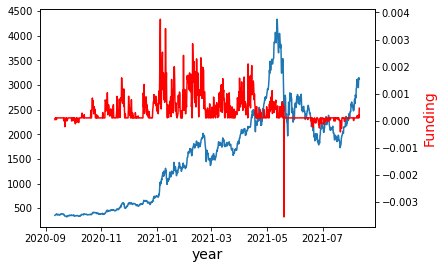

In [ ]:
fig,ax=plt.subplots()

ax.plot(graph.index, graph['close_spot'])
ax.set_xlabel("year",fontsize=14)

ax2=ax.twinx()
ax2.plot(graph.index, graph['fundingRate'],color="red")
ax2.set_ylabel("Funding",color="red",fontsize=14)

#ax3=ax.twinx()
#ax3.plot(graph.index, graph['std42'],color="green")
#ax2.set_ylabel("Std",color="green",fontsize=14)


plt.show();

* It stands out that volatility and market movement are the principal regressors
* We will try to use them as ATR and RSI

## ATR

In [ ]:
svod["high_low"] = svod["high_spot"] - svod["low_spot"]
svod["high_close"] = np.abs(svod["high_spot"] - svod["close_spot"].shift())
svod["low_close"] = np.abs(svod["low_spot"] - svod["close_spot"].shift())
svod["true_range"] = np.max(svod[["low_close", 'high_close', 'high_low']], axis=1)
svod["atr"] = svod["true_range"].rolling(14).sum()/14

In [ ]:
graph = None 
graph = svod[['fundingTime', 'true_range', 'fundingRate']]
graph = graph.set_index(graph['fundingTime'])
graph = graph.drop('fundingTime', axis=1)
garph = graph.dropna()

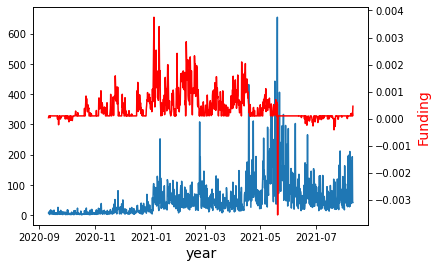

In [ ]:
fig,ax=plt.subplots()

ax.plot(graph.index, graph['true_range'])
ax.set_xlabel("year",fontsize=14)

ax2=ax.twinx()
ax2.plot(graph.index, graph['fundingRate'],color="red")
ax2.set_ylabel("Funding",color="red",fontsize=14)


plt.show();

## RSI

In [ ]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['close_spot'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [ ]:
svod['rsi']=rsi(svod[['close_spot']])

In [ ]:
graph = None 
graph = svod[['fundingTime', 'rsi', 'fundingRate']]
graph = graph.set_index(graph['fundingTime'])
graph = graph.drop('fundingTime', axis=1)
garph = graph.dropna()

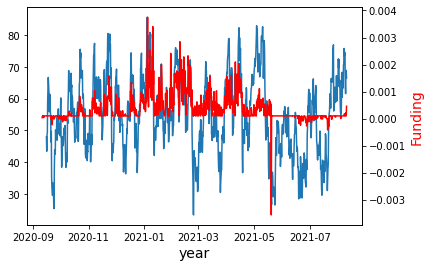

In [ ]:
fig,ax=plt.subplots()

ax.plot(graph.index, graph['rsi'])
ax.set_xlabel("year",fontsize=14)

ax2=ax.twinx()
ax2.plot(graph.index, graph['fundingRate'],color="red")
ax2.set_ylabel("Funding",color="red",fontsize=14)


plt.show();

## Trends

In [ ]:
svod = svod.dropna()
svod['SMA1'] = svod["close_spot"].rolling(9).mean()
svod['SMA2'] = svod["close_spot"].rolling(126).mean()

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_72443/3941584817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod['SMA1'] = svod["close_spot"].rolling(9).mean()
/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_72443/3941584817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod['SMA2'] = svod["close_spot"].rolling(126).mean()


<AxesSubplot:title={'center':'ETH-USD | 42 & 252 days SMAs'}>

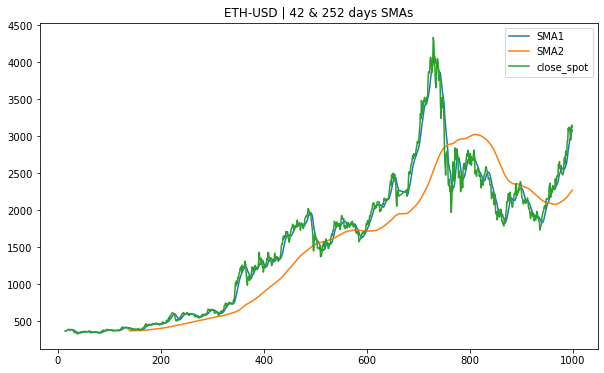

In [ ]:
svod[["SMA1", "SMA2", "close_spot"]].plot(title = "ETH-USD | 42 & 252 days SMAs", figsize=(10, 6))

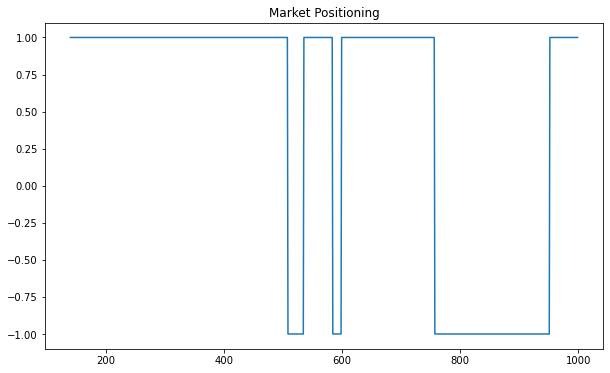

In [ ]:
svod['position'] = np.where(svod['SMA1'] > svod['SMA2'],1,-1)
svod.dropna(inplace=True)
svod['position'].plot(ylim=[-1.1, 1.1],
                      title='Market Positioning',
                      figsize=(10, 6));

* Никакого результата, убрать

In [ ]:
svod['returns_spot'] = svod['close_spot'].pct_change()
svod['returns_fut'] = svod['close_fut'].pct_change()

In [ ]:
svod.columns

Index(['fundingTime', 'fundingRate', 'date', 'time', 'open_spot', 'high_spot',
       'low_spot', 'close_spot', 'volume_spot', 'open_fut', 'high_fut',
       'low_fut', 'close_fut', 'volume_fut', 'high_low', 'high_close',
       'low_close', 'true_range', 'atr', 'rsi', 'SMA1', 'SMA2', 'position',
       'returns_spot', 'returns_fut'],
      dtype='object')

In [ ]:
svod.head()

,fundingTime,fundingRate,date,time,open_spot,high_spot,low_spot,close_spot,volume_spot,open_fut,...,high_close,low_close,true_range,atr,rsi,SMA1,SMA2,position,returns_spot,returns_fut
139,2020-10-27 11:00:00.000,0.000100,27/10/2020,11:00:00,396.20000000,403.50,395.50,402.29,76820.30027,396.38,...,10.60,2.60,10.60,5.911429,54.160945,404.907778,368.137698,1,NaN,NaN
140,2020-10-27 19:00:00.000,0.000184,27/10/2020,19:00:00,405.85000000,407.35,404.86,406.16,17703.44958,406.23,...,5.06,2.57,5.06,6.053571,56.809537,404.126667,368.467063,1,0.009620,0.010090
141,2020-10-28 03:00:00.000,0.000153,28/10/2020,03:00:00,408.06000000,408.14,404.45,405.79,35095.50503,408.29,...,1.98,1.71,3.69,5.900714,56.473567,403.092222,368.834524,1,-0.000911,-0.001156
142,2020-10-28 11:00:00.006,0.000100,28/10/2020,11:00:00,394.67000000,394.71,386.50,386.86,83120.54756,394.55,...,11.08,19.29,19.29,6.550714,42.594366,400.851111,369.010952,1,-0.046650,-0.047394
143,2020-10-28 19:00:00.001,0.000100,28/10/2020,19:00:00,386.23000000,386.83,383.89,384.69,20983.38118,386.28,...,0.03,2.97,2.97,6.422143,41.340114,398.250000,369.165000,1,-0.005609,-0.005301


### *** MACD 26 12 9

In [ ]:
macd = svod[['fundingTime', 'close_spot']]

In [ ]:
macd['evm12'] = macd['close_spot'].ewm(span=12, adjust=False, min_periods=12).mean()
macd['evm26'] = macd['close_spot'].ewm(span=26, adjust=False, min_periods=26).mean()
macd['macd'] = macd['evm26'] - macd['evm12']
macd['macd_s'] = macd['macd'].ewm(span=9, adjust=False, min_periods=9).mean()
macd['macd_h'] = macd['macd'] - macd['macd_s']
macd.tail()

,fundingTime,close_spot,evm12,evm26,macd,macd_s,macd_h
995,2021-08-08 19:00:00.018,2984.44,2920.919365,2746.875691,-174.043674,-152.226878,-21.816796
996,2021-08-09 03:00:00.000,2948.31,2925.133309,2761.796751,-163.336558,-154.448814,-8.887744
997,2021-08-09 11:00:00.000,3133.42,2957.177415,2789.324399,-167.853016,-157.129654,-10.723362
998,2021-08-09 19:00:00.002,3147.74,2986.494736,2815.873703,-170.621033,-159.827930,-10.793103
999,2021-08-10 03:00:00.000,3115.39,3006.324777,2838.060095,-168.264681,-161.515280,-6.749401


<AxesSubplot:>

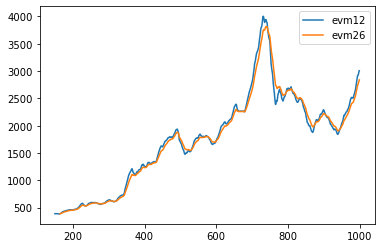

In [ ]:
macd[['evm12', 'evm26']].plot()

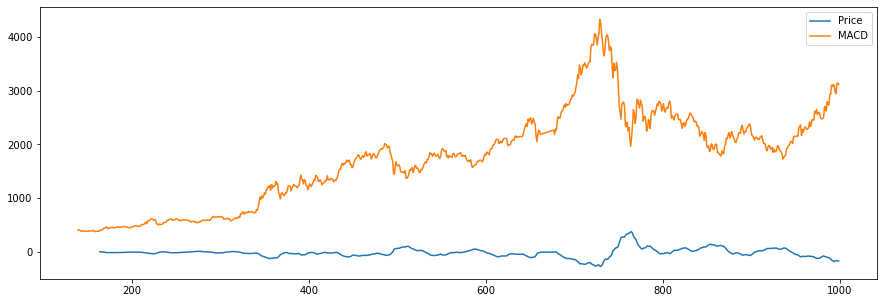

In [ ]:
ax = macd[['macd']].plot(figsize=(15, 5))
macd['close_spot'].plot()
plt.legend(['Price', 'MACD'])
plt.show()

In [ ]:
macd

,fundingTime,close_spot,evm12,evm26,macd,macd_s,macd_h
139,2020-10-27 11:00:00.000,402.29,NaN,NaN,NaN,NaN,NaN
140,2020-10-27 19:00:00.000,406.16,NaN,NaN,NaN,NaN,NaN
141,2020-10-28 03:00:00.000,405.79,NaN,NaN,NaN,NaN,NaN
142,2020-10-28 11:00:00.006,386.86,NaN,NaN,NaN,NaN,NaN
143,2020-10-28 19:00:00.001,384.69,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
995,2021-08-08 19:00:00.018,2984.44,2920.919365,2746.875691,-174.043674,-152.226878,-21.816796
996,2021-08-09 03:00:00.000,2948.31,2925.133309,2761.796751,-163.336558,-154.448814,-8.887744
997,2021-08-09 11:00:00.000,3133.42,2957.177415,2789.324399,-167.853016,-157.129654,-10.723362
998,2021-08-09 19:00:00.002,3147.74,2986.494736,2815.873703,-170.621033,-159.827930,-10.793103


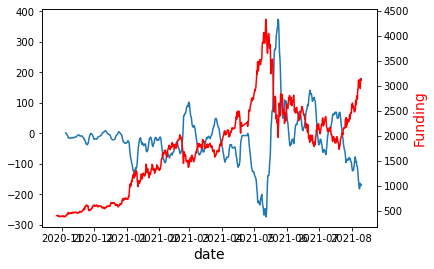

In [ ]:
fig,ax=plt.subplots()

ax.plot(macd['fundingTime'], macd['macd'])
ax.set_xlabel("date",fontsize=14)

ax2=ax.twinx()
ax2.plot(macd['fundingTime'], macd['close_spot'],color="red")
ax2.set_ylabel("Funding",color="red",fontsize=14)


plt.show();

## DrawDown

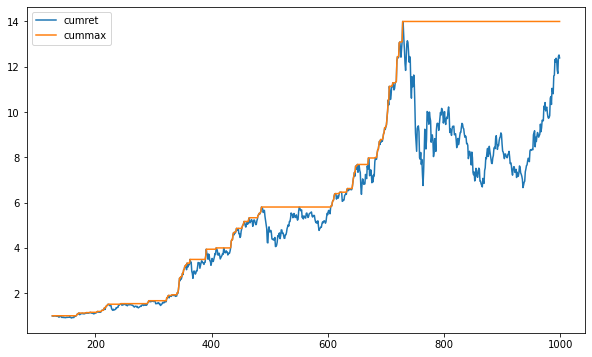

In [ ]:
svod['cumret'] = svod['returns_spot'].cumsum().apply(np.exp)
svod['cummax']= svod['cumret'].cummax()
svod[['cumret', 'cummax']].dropna().plot(figsize=(10,6));

In [ ]:
svod['drawdown'] = svod['cummax'] - svod['cumret']

In [ ]:
svod['std42'] = svod["close_spot"].rolling(42).std()

# Modeling

## Linear Regression

In [ ]:
svod[['fundingRate', 'volume_spot', 'volume_fut', 'position', 'returns_spot', 'returns_fut','drawdown' ]].corr()

,fundingRate,volume_spot,volume_fut,position,returns_spot,returns_fut,drawdown
fundingRate,1.000000,0.002440,-0.123228,0.437672,0.032992,0.030513,-0.589977
volume_spot,0.002440,1.000000,0.883696,0.128197,-0.255813,-0.256744,0.005745
volume_fut,-0.123228,0.883696,1.000000,-0.042780,-0.296531,-0.297540,0.211911
position,0.437672,0.128197,-0.042780,1.000000,0.000260,-0.000003,-0.735221
returns_spot,0.032992,-0.255813,-0.296531,0.000260,1.000000,0.999623,-0.112152
returns_fut,0.030513,-0.256744,-0.297540,-0.000003,0.999623,1.000000,-0.112176
drawdown,-0.589977,0.005745,0.211911,-0.735221,-0.112152,-0.112176,1.000000


In [ ]:
svod  = svod.dropna()
X = svod[['volume_spot', 'volume_fut', 'position', 'returns_spot', 'returns_fut','drawdown' ]].values
y = svod['fundingRate'].values

### Train Test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

### Train

In [ ]:
lr.fit(X_train,y_train)

LinearRegression()

### Predict

In [ ]:
y_pred = lr.predict(X_test)

### Evaluate the model

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.37607522802214033

In [ ]:
svod['volume_spot_change'] = svod['volume_spot'].pct_change()
svod['volume_fut_change'] = svod['volume_fut'].pct_change()

In [ ]:
svod2['fundingRate'] = [np.float32(x) for x in svod2['fundingRate']]
svod2['returns_spot'] = [np.float32(x) for x in svod2['returns_spot']]
svod2['rsi'] = [np.float32(x) for x in svod2['rsi']]
svod2['atr'] = [np.float32(x) for x in svod2['atr']]
svod2['returns_fut'] = [np.float32(x) for x in svod2['returns_fut']]
svod2['drawdown'] = [np.float32(x) for x in svod2['drawdown']]
svod2['volume_spot_change'] = [np.float32(x) for x in svod2['volume_spot_change']]
svod2['volume_fut_change'] = [np.float32(x) for x in svod2['volume_fut_change']]

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/4150692481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2['fundingRate'] = [np.float32(x) for x in svod2['fundingRate']]
/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/4150692481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2['returns_spot'] = [np.float32(x) for x in svod2['returns_spot']]
/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/4150692481.py:3: SettingWithCopyWarning: 
A value i

In [ ]:
svod2[['position',
       'returns_spot',
       'rsi',
       'atr',
       'returns_fut',
       'drawdown',
       'volume_spot_change',
       'volume_fut_change' ]] = svod2[['position', 'returns_spot', 'rsi', 'atr',
                                       'returns_fut','drawdown', 'volume_spot_change',
                                       'volume_fut_change' ]].shift()
svod2  = svod2.dropna()

## XGBOOST

In [ ]:
FEATURES = ['position', 'returns_spot', 'rsi', 'atr', 'returns_fut',
       'drawdown', 'volume_spot_change', 'volume_fut_change']
TARGET = 'fundingRate'

In [ ]:
X_train = svod2[FEATURES]
X_test = svod2[FEATURES]
y_train = svod2[TARGET]
y_test = svod2[TARGET]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[19:03:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49458	validation_1-rmse:0.49458
[100]	validation_0-rmse:0.18125	validation_1-rmse:0.18125
[200]	validation_0-rmse:0.06642	validation_1-rmse:0.06642
[300]	validation_0-rmse:0.02435	validation_1-rmse:0.02435
[400]	validation_0-rmse:0.00894	validation_1-rmse:0.00894
[500]	validation_0-rmse:0.00331	validation_1-rmse:0.00331
[600]	validation_0-rmse:0.00127	validation_1-rmse:0.00127
[700]	validation_0-rmse:0.00057	validation_1-rmse:0.00057
[800]	validation_0-rmse:0.00039	validation_1-rmse:0.00039
[900]	validation_0-rmse:0.00036	validation_1-rmse:0.00036
[999]	validation_0-rmse:0.00036	validation_1-rmse:0.00036


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

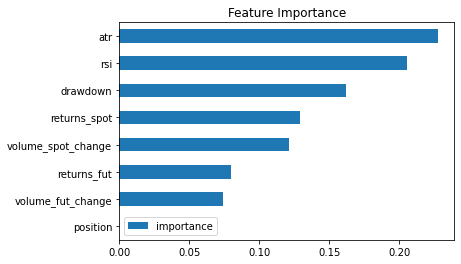

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/2182633181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2['prediction'] = reg.predict(X_test)


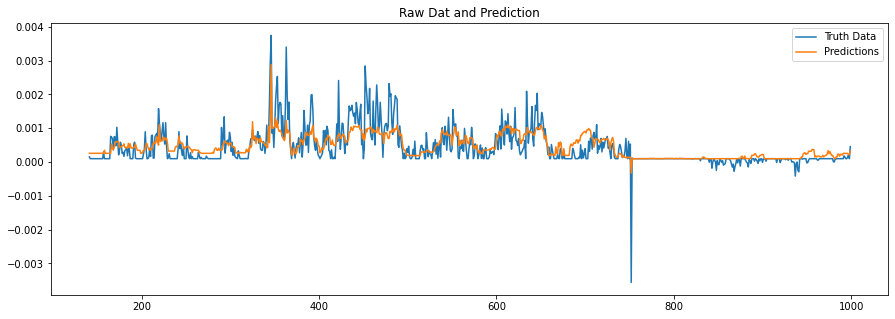

In [ ]:
svod2['prediction'] = reg.predict(X_test)
#df = df.merge(svod2[['prediction']], how='left', left_index=True, right_index=True)
ax = svod2[['fundingRate']].plot(figsize=(15, 5))
svod2['prediction'].plot()
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/1121668864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2["difference"] = svod2['fundingRate'] - svod2['prediction']


Text(0.5, 1.0, 'Spread Between FTX and Binance Futures')

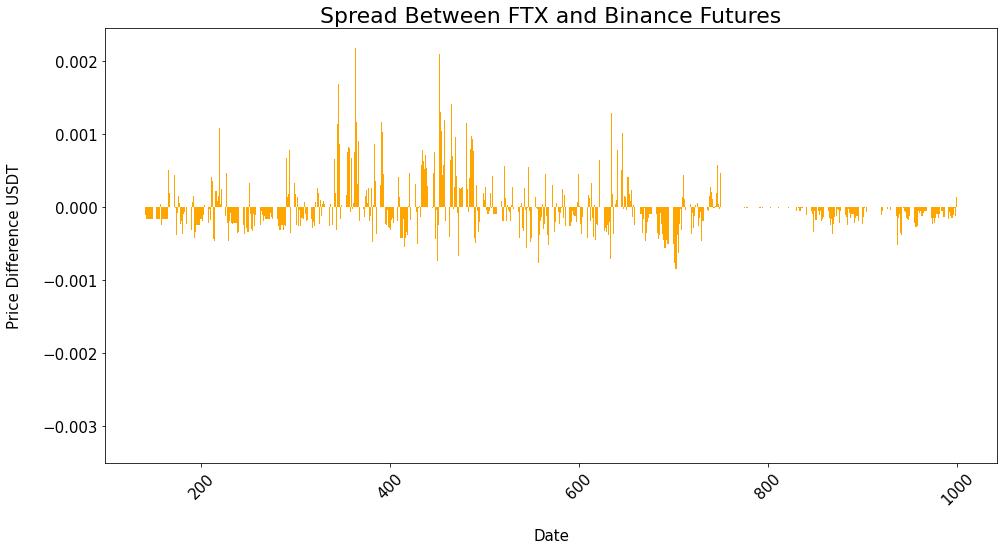

In [ ]:
# Сравнение цен квартального фьюча бинанса и ftx
svod2["difference"] = svod2['fundingRate'] - svod2['prediction']

plt.figure(figsize=(16,8))
plt.bar(x=svod2.index, height = svod2["difference"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price Difference USDT", fontsize =15, labelpad =20)
plt.title("Spread Between FTX and Binance Futures", fontsize =22)

In [ ]:
svod2[['fundingRate', 'prediction']].sample(5)

,fundingRate,prediction
343,0.000744,0.001057
581,0.000331,0.000349
937,-0.000416,0.000098
141,0.000153,0.000259
580,0.000199,0.000275


In [ ]:
score = np.sqrt(mean_squared_error(svod2['fundingRate'], svod2['prediction']))
score

0.0003601076

In [ ]:
from sklearn.metrics import r2_score
r2_score(svod2['fundingRate'], svod2['prediction'])

0.548805775276082

In [ ]:
svod2["fundingRate_shift"] = svod2["fundingRate"].shift()

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/3150556675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2["fundingRate_shift"] = svod2["fundingRate"].shift()


## XGBOSST Level 2

In [ ]:
FEATURES = ['position', 'returns_spot', 'rsi', 'atr', 'returns_fut',
       'drawdown', 'volume_spot_change', 'volume_fut_change', 'fundingRate_shift']
TARGET = 'fundingRate'

In [ ]:
X_train = svod2[FEATURES]
X_test = svod2[FEATURES]
y_train = svod2[TARGET]
y_test = svod2[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[19:30:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49458	validation_1-rmse:0.49458
[100]	validation_0-rmse:0.18125	validation_1-rmse:0.18125
[200]	validation_0-rmse:0.06642	validation_1-rmse:0.06642
[300]	validation_0-rmse:0.02435	validation_1-rmse:0.02435
[400]	validation_0-rmse:0.00894	validation_1-rmse:0.00894
[500]	validation_0-rmse:0.00330	validation_1-rmse:0.00330
[600]	validation_0-rmse:0.00125	validation_1-rmse:0.00125
[700]	validation_0-rmse:0.00055	validation_1-rmse:0.00055
[800]	validation_0-rmse:0.00036	validation_1-rmse:0.00036
[900]	validation_0-rmse:0.00033	validation_1-rmse:0.00033
[999]	validation_0-rmse:0.00032	validation_1-rmse:0.00032


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/1455214883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2['prediction2'] = reg.predict(X_test)


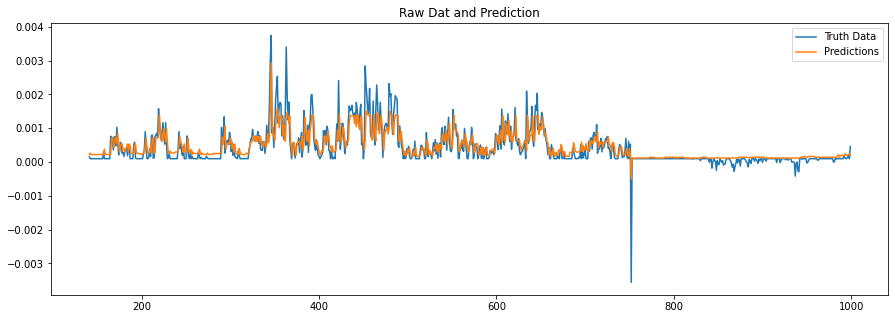

In [ ]:
svod2['prediction2'] = reg.predict(X_test)
ax = svod2[['fundingRate']].plot(figsize=(15, 5))
svod2['prediction2'].plot()
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
r2_score(svod2['fundingRate'], svod2['prediction2'])

0.6326534155609355

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/459612834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2["difference"] = svod2['fundingRate'] - svod2['prediction2']


Text(0.5, 1.0, 'Spread Between FTX and Binance Futures')

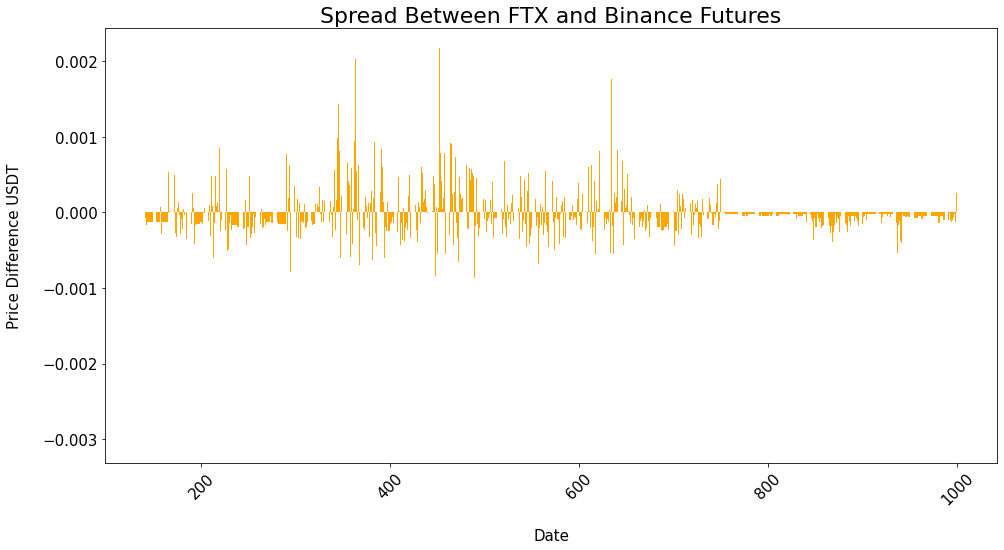

In [ ]:
# Сравнение цен квартального фьюча бинанса и ftx
svod2["difference"] = svod2['fundingRate'] - svod2['prediction2']

plt.figure(figsize=(16,8))
plt.bar(x=svod2.index, height = svod2["difference"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price Difference USDT", fontsize =15, labelpad =20)
plt.title("Spread Between FTX and Binance Futures", fontsize =22)

add Hyperparameters tuning

In [ ]:
Pygam

In [ ]:
svod2["difference"]

141   -0.000071
142   -0.000163
143   -0.000123
144   -0.000123
145   -0.000123
         ...   
995   -0.000099
996   -0.000054
997   -0.000019
998   -0.000132
999    0.000258
Name: difference, Length: 858, dtype: float32

In [ ]:
svod2['prediction2_plus0001'] = svod2['prediction2'] - 0.0001
svod2["difference2_plus0001"] = svod2['fundingRate'] - svod2['prediction2_plus0001']
svod2["difference2_plus0001"]

/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/3174669244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2['prediction2_plus0001'] = svod2['prediction2'] - 0.0001
/var/folders/q_/fz2ylcb14dqcs8bp2t8hjz6m0000gn/T/ipykernel_68586/3174669244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svod2["difference2_plus0001"] = svod2['fundingRate'] - svod2['prediction2_plus0001']


141    2.925814e-05
142   -6.297493e-05
143   -2.327187e-05
144   -2.327187e-05
145   -2.327187e-05
           ...     
995    7.742201e-07
996    4.590369e-05
997    8.127950e-05
998   -3.174050e-05
999    3.581142e-04
Name: difference2_plus0001, Length: 858, dtype: float32

Text(0.5, 1.0, 'Spread Between FTX and Binance Futures')

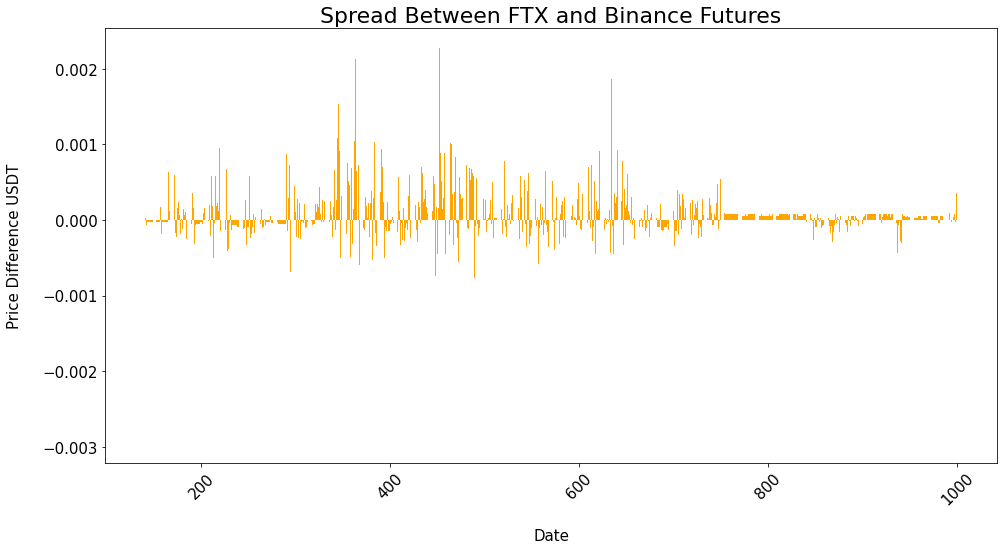

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(x=svod2.index, height = svod2["difference2_plus0001"], color = "orange")


plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Price Difference USDT", fontsize =15, labelpad =20)
plt.title("Spread Between FTX and Binance Futures", fontsize =22)

## LSTM model

In [ ]:
import pandas as pd